# Deep Learning in Stock Market Trading - A Comparitive Analysis
In this notebook, we're going to compare several stock trading models, from rudimentary methods like momentum/MACD trading to simple machine learning methods like linear regression, to more sophisticated deep learning models.

We're going to use several macroeconomic variables, alongside manually calculated technical indicators like MACD, RSI and ATR. We also use wavelet transformations to denoise some of our features.

In this study we're analysing the price history of the S&P 500, a stock market index tracking the stock performance of 500 of the largest companies listed on stock exchanges in the United States. We will aim to predict the price of it and make trades accordingly to maximize profit.

#### Topics covered:
- Data collection and cleaning
- Feature engineering and noise reduction
- Data scaling
- Model implementation and comparison
- Shallow and deep learning methods
- LSTM implementation in Tensorflow

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

color_pal = sns.color_palette('coolwarm')

# **Dataset**
### S&P 500 Index
- A popular US stock market index is used for model prediction.
- 15 years of daily data from 2006 to 2020 are to be used.
- Core factors that contribute to the index value fluctuations will be selected during feature selection.
- Some features, such as technical indicators will be directly calculated using price data.
- Macroeconomic variables are selected based on their potential impact on the overall economy and broader markets.
- We have two major bear markets in our data (financial crisis of 2008 and the COVID-19 pandemic in 2020. Thus the model contains information from both bull and bear markets.

# **Features**
The input variables used to make predictions.

## **Fundamental:**
### Open price (Open)
Open price is the first transaction price upon the opening of a market on a trading day.

Downloaded daily historical data from Stooq.

### Close price (Close)
Closing price is the last price at which the stock is traded during that day.

Downloaded daily historical data from Stooq.

## **Macroeconomic variables:**
Macroeconomic variables are economic indicators that measure the overall performance and health of an economy, such as GDP, inflation, unemployment rate, and interest rates. These variables can provide insight into the broader economic conditions that may affect the performance of individual stocks or the stock market as a whole.

### CBOE Volatility Index (VIX)
The CBOE Volatility Index, also known as the VIX, is a measure of the expected volatility of the S&P 500 index over the next 30 days. It is often referred to as the "Fear Index" or the "Fear Gauge" because it is used to gauge the level of fear or stress in the stock market.

If the VIX is low, this indicates investors are not too concerned about short-term market volatility. They feel confident and optimistic about the near future. Conversely, if the VIX is high, it may indicate that investors are more uncertain about the future and are more likely to sell their stocks, which can lead to lower stock prices.

Downloaded daily historical data from Yahoo Finance.

### Interest rate (EFFR)
Interest rate refers to the percentage at which borrowing or lending money is done. Central banks, such as the Federal Reserve in the United States, set interest rates to control inflation and manage the overall health of the economy. When interest rates are high, it becomes more expensive for individuals and businesses to borrow money, which can lead to slower economic growth. When interest rates are low, it becomes cheaper to borrow money, which can encourage spending and investment, leading to economic growth.

Interest rates can be an important macroeconomic variable to include as a feature in a stock price prediction model because changes in interest rates can affect the profitability of companies and the overall performance of the stock market. For example, if interest rates are low, it can be cheaper for companies to borrow money and invest in growth, which can lead to higher stock prices. Similarly, if interest rates are high, it can become more expensive for companies to borrow money, which can lead to lower stock prices.

Downloaded daily historical data from FRED.

### Civilian unemployment rate (UNRATE)
The civilian unemployment rate is a measure of the percentage of individuals in the civilian labor force who are unemployed but actively seeking employment and willing to work. It is calculated by the Bureau of Labor Statistics (BLS) and is released on a monthly basis.

A low unemployment rate generally indicates that the economy is strong, and that businesses are hiring and expanding. On the other hand, a high unemployment rate can indicate that the economy is weak, and that businesses are cutting jobs and slowing down.

Downloaded monthly historical data up to December from FRED.

### Consumer sentiment index (UMCSENT)
The consumer sentiment index is a measure of consumer confidence, which reflects how consumers feel about the current and future state of the economy.

The consumer sentiment index is a useful measure to include because consumer confidence is closely tied to consumer spending, which drives economic growth and is a key driver of corporate profits. When consumers are confident and optimistic about the future, they are more likely to spend money on goods and services. Conversely, when consumers are pessimistic and uncertain about the future, they are less likely to spend money, which can lead to lower sales and profits for companies and lower stock prices.

Downloaded monthly historical data up to November 2022 from Fred

### The US Dollar Index (USDX)
The US Dollar Index (USDX) is a measure of the value of the United States dollar relative to a basket of other major currencies.

A stronger dollar can make exports more expensive, hurting companies that export a lot of goods, which can lead to lower stock prices. Conversely, a weaker dollar can make exports cheaper, making companies more competitive in the global market, which can lead to higher stock prices.

Downloaded daily historical data from Yahoo Finance.

## **Technical indicators:**
Technical indicators are mathematical calculations that are based on the price and/or volume of a security. They are used to identify patterns and trends in the price of a security, and can be used to make predictions about future price movements.

### Moving average convergence divergence (MACD)
MACD (Moving Average Convergence Divergence) is a popular technical indicator that is used to identify trends and momentum in the price of a security. 

The MACD is calculated by subtracting the 26-period exponential moving average (EMA) of a security's price from the 12-period EMA of its price. This removes all the short term trading signals, producing a more stable, mid-term momentum signal line.  

The MACD is often used in combination with a signal line, which is a 9-period EMA of the MACD. The fast moving MACD line crossing the slower signal line indicates a change in momentum. 

### Average true range (ATR) 
The Average True Range (ATR) is a technical indicator that measures the volatility of a stock or other financial security. 

If the ATR is high, it means that the market is experiencing a lot of volatility and that prices are likely to be more unpredictable. On the other hand, if the ATR is low, it means that the market is relatively stable, and prices are more likely to follow a predictable pattern.

We are going to use a 14 day ATR period.

### Relative strength index (RSI)
The RSI is a technical indicator that helps traders understand if a stock or other financial instrument is overbought or oversold. It compares the magnitude of recent gains to recent losses to determine overbought and oversold conditions of an asset.

A value above 70 on the RSI is considered overbought, which means that the stock price is high and may fall soon. On the other hand, a value below 30 on the RSI is considered oversold, which means that the stock price is low and may increase soon.

# Loading the data
Here we're loading our fundamental data as well as macroeconomic variables.

Technical indicators will be manually calculated later.

In [2]:
df_sp = pd.read_csv('/kaggle/input/sp500-and-auxiliary-financial-data/SP500.csv')
df_unrate = pd.read_csv('/kaggle/input/sp500-and-auxiliary-financial-data/UNRATE.csv')
df_usdx = pd.read_csv('/kaggle/input/sp500-and-auxiliary-financial-data/USDX.csv')
df_vix = pd.read_csv('/kaggle/input/sp500-and-auxiliary-financial-data/VIX.csv')
df_umcsent = pd.read_csv('/kaggle/input/sp500-and-auxiliary-financial-data/UMCSENT.csv')
df_effr = pd.read_csv('/kaggle/input/sp500-and-auxiliary-financial-data/EFFR.csv')

# Data cleaning
### Reformatting our DataFrames
Let's convert the date columns of each DataFrame to the datetime format which we will be working with later.

We then want every Dataframe (except the S&P 500 frame) to have two columns, Date and Value.

We then need to delete and rename columns from various DataFrames. That will all be handled in the cell below:

In [3]:
for df in [df_sp, df_unrate, df_usdx, df_vix, df_umcsent, df_effr]:
    df.Date = pd.to_datetime(df.Date)

df_usdx = df_usdx.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df_usdx = df_usdx.rename(columns = {'Close':'USDX'})

df_vix = df_vix.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df_vix = df_vix.rename(columns = {'Close':'VIX'})

df_effr = df_effr.replace('.', np.nan)

### Missing dates
Our primary DataFrame (S&P 500) has many missing days due to weekends and holidays in the US at these times.

We are going to address this by processing the timeseries data as a continuous signal, as though weekends and holidays take up no time. 

To address the possibility that some macroeconomic data may be missing on days where the S&P 500 has data, we're going to forward fill all macroeconomic data so that we have it for every day. 

We also have 2 DataFrames that contain monthly data (unemployment rate and consumer sentiment), so we're going to break those two metrics into daily data and forward fill missing values so each month contains all the same values.

We're then going to use the S&P DataFrame as a base. Add in missing dates, then concatenate it with the other macroeconomic variables. Any rows missing close or open price data will be deleted.

The data will then be processed sequentially, and a dictionary containing keys from each row index to the date it corresponds to will be stored.

In [4]:
df_sp = df_sp.set_index('Date')
df_unrate = df_unrate.set_index('Date').resample('D').ffill()
df_usdx = df_usdx.set_index('Date').resample('D').ffill()
df_vix = df_vix.set_index('Date').resample('D').ffill()
df_umcsent = df_umcsent.set_index('Date').resample('D').ffill()
df_effr = df_effr.set_index('Date').resample('D').ffill()

macro_df = pd.concat([df_unrate, df_usdx, df_vix, df_umcsent, df_effr], axis=1)
macro_df.head()

,UNRATE,USDX,VIX,UMCSENT,EFFR
Date,,,,,
2003-01-01,5.8,NaN,NaN,82.4,NaN
2003-01-02,5.8,102.980003,25.389999,82.4,1.30
2003-01-03,5.8,102.470001,24.680000,82.4,1.12
2003-01-04,5.8,102.470001,24.680000,82.4,1.12
2003-01-05,5.8,NaN,24.680000,82.4,1.12


### Checking for missing data
We're going to use a heatmap to display missing data/NaN values. Missing data is highlighted in white.

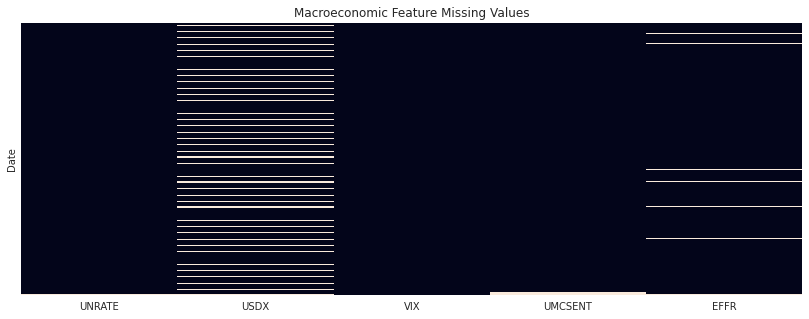

In [ ]:
fig, axis = plt.subplots(1,1, figsize=(14,5))

sns.heatmap(macro_df.isnull(),
            cbar=False,
            cmap='rocket',
            yticklabels=False,
            ax=axis)

axis.set_title('Macroeconomic Feature Missing Values')
fig.show()

### Observations:
- We're missing a full month of data at the end for UNRATE and UMCSENT.
- We're also missing a large amount of USDX data.

### Solution:
- We're going to forward fill all missing data.
- Then we're going to backward fill the first day of 2003 for a few features.

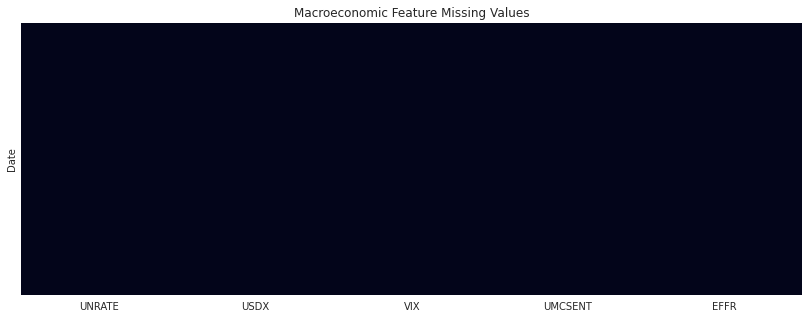

In [6]:
macro_df.fillna(method="ffill", inplace=True)
macro_df.fillna(method="bfill", inplace=True)

fig, axis = plt.subplots(1,1, figsize=(14,5))

sns.heatmap(macro_df.isnull(),
            cbar=False,
            cmap='rocket',
            yticklabels=False,
            ax=axis)

axis.set_title('Macroeconomic Feature Missing Values')
fig.show()

#### Observations:
- We've cleaned our macroeconomic features.
- Since US stocks do not trade on weekends and some holidays, we are missing data on many days throughout our dataframe. We're going to handle this by simply removing these days from our dataframe. These missing days can be seen below:

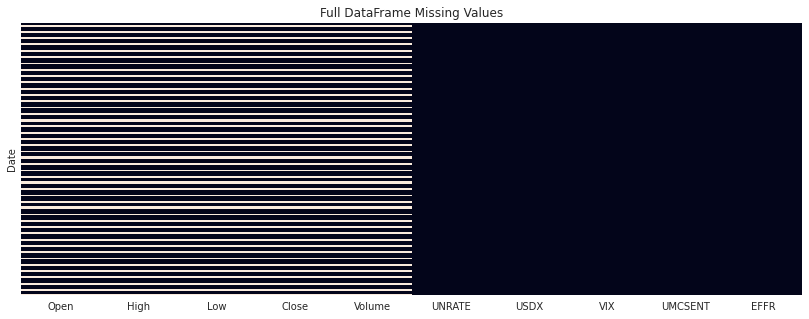

In [7]:
df = pd.concat([df_sp, macro_df], axis=1)

fig, axis = plt.subplots(1,1, figsize=(14,5))

sns.heatmap(df.isnull(),
            cbar=False,
            cmap='rocket',
            yticklabels=False,
            ax=axis)

axis.set_title('Full DataFrame Missing Values')
fig.show()

In [8]:
df.dropna(inplace=True)
df.insert(0, 'ID', range(0, len(df)))
df.head()

,ID,Open,High,Low,Close,Volume,UNRATE,USDX,VIX,UMCSENT,EFFR
Date,,,,,,,,,,,
2003-01-02,0,879.82,909.03,879.82,909.03,682888889.0,5.8,102.980003,25.389999,82.4,1.30
2003-01-03,1,909.03,911.25,903.07,908.59,628222222.0,5.8,102.470001,24.680000,82.4,1.12
2003-01-06,2,908.59,931.77,908.59,929.01,797722222.0,5.8,101.970001,24.910000,82.4,1.22
2003-01-07,3,929.01,930.81,919.93,922.93,858444444.0,5.8,102.570000,25.129999,82.4,1.20
2003-01-08,4,922.93,922.93,908.32,909.93,815333333.0,5.8,101.870003,25.530001,82.4,1.29


In [9]:
df.tail()

,ID,Open,High,Low,Close,Volume,UNRATE,USDX,VIX,UMCSENT,EFFR
Date,,,,,,,,,,,
2022-12-27,5031,3843.34,3846.65,3813.22,3829.25,1.753562e+09,3.5,104.180000,21.650000,56.8,4.33
2022-12-28,5032,3829.56,3848.32,3780.78,3783.22,1.741219e+09,3.5,104.459999,22.139999,56.8,4.33
2022-12-29,5033,3805.45,3858.19,3805.45,3849.28,1.734475e+09,3.5,103.839996,21.440001,56.8,4.33
2022-12-30,5034,3829.06,3839.85,3800.34,3839.50,1.704123e+09,3.5,103.519997,21.670000,56.8,4.33
2023-01-03,5035,3853.29,3878.46,3794.33,3824.14,2.351704e+09,3.5,104.519997,22.900000,56.8,4.33


### Displaying the full dataset

The full 20 years of data we have available to use for our model, including training, validation and testing data.

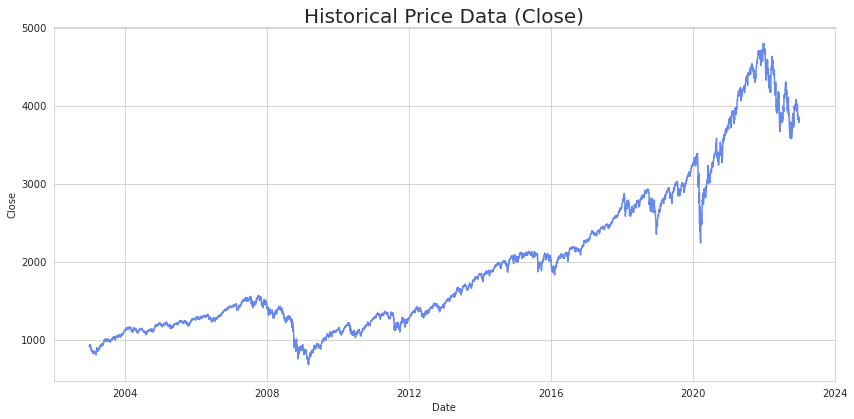

In [10]:
fig, ax = plt.subplots(figsize=(14,6.5))

sns.lineplot(data=df, 
             x=df.index, 
             y='Close', 
             linewidth=1.5,
             color=color_pal[0],
             ax=ax)

ax.set_title('Historical Price Data (Close)', fontsize=20)
plt.show()


# Technical Indicators

### MACD calculation with Pandas

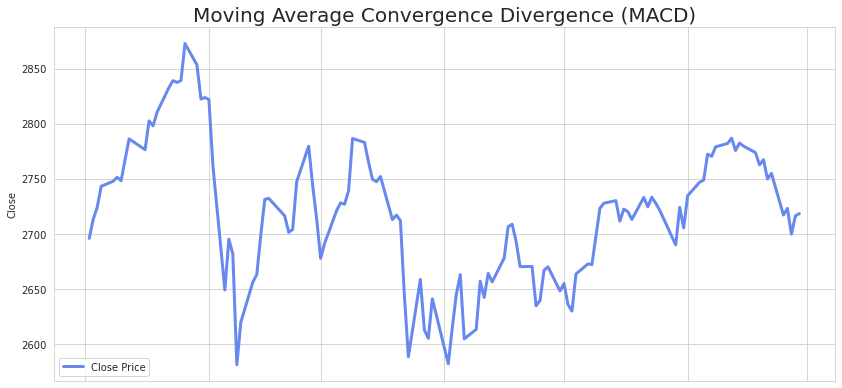

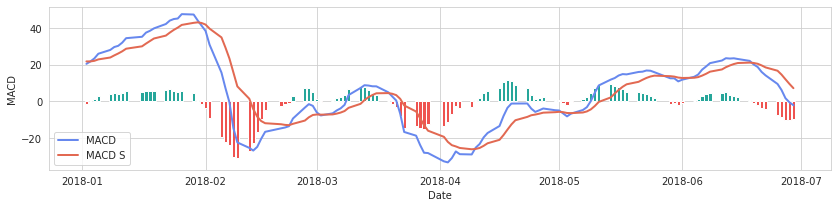

In [11]:
# Create a MACD feature

# Get the 12-day EMA of the closing price
fast_ema = df['Close'].ewm(span=12, adjust=False).mean()

# Get the 26-day EMA of the closing price
slow_ema = df['Close'].ewm(span=26, adjust=False).mean()

# Subtract the 26-Day EMA the 12-day EMA to get the MACD
MACD = fast_ema - slow_ema

# Get the 9-Day EMA of the MACD for the trigger line
MACD_S = MACD.ewm(span=9, adjust=False).mean()

# Calculate the difference between the MACD - trigger for the convergence/divergence value
MACD_H = MACD - MACD_S

# Add all of our new values for the MACD to the dataframe
df['MACD'] = df.index.map(MACD)
df['MACD_S'] = df.index.map(MACD_S)
df['MACD_H'] = df.index.map(MACD_H)


# Use a short period of time to plot our newly created feature

df_slice = df.loc[df.index.year == 2018]
df_slice = df_slice.loc[df_slice.index < '2018-07-01']

fig, ax = plt.subplots(figsize=(14,6.5))

sns.lineplot(data=df_slice, 
             x=df_slice.index, 
             y='Close', 
             linewidth=3,
             color=color_pal[0],
             ax=ax)

ax.set(xticklabels=[])
ax.set(xlabel=None)
ax.legend(['Close Price'], loc='lower left')
ax.set_title('Moving Average Convergence Divergence (MACD)', fontsize=20)
plt.show()


fig, ax = plt.subplots(figsize=(14,3) )
sns.lineplot(data=df_slice, 
             x=df_slice.index,
             y='MACD',
             linewidth=2,
             color=color_pal[0],
             ax=ax)

sns.lineplot(data=df_slice, 
             x=df_slice.index,
             y='MACD_S',
             linewidth=2,
             color=color_pal[5],
             ax=ax)

for i in range(len(df_slice.Close)):
        if str(df_slice.MACD_H[i])[0] == '-':
            ax.bar(df_slice.index[i], df_slice.MACD_H[i], color = '#ef5350')
        else:
            ax.bar(df_slice.index[i], df_slice.MACD_H[i], color = '#26a69a')

ax.legend(['MACD', 'MACD S'], loc='lower left')
plt.show()

### Average true range calculation with Pandas 

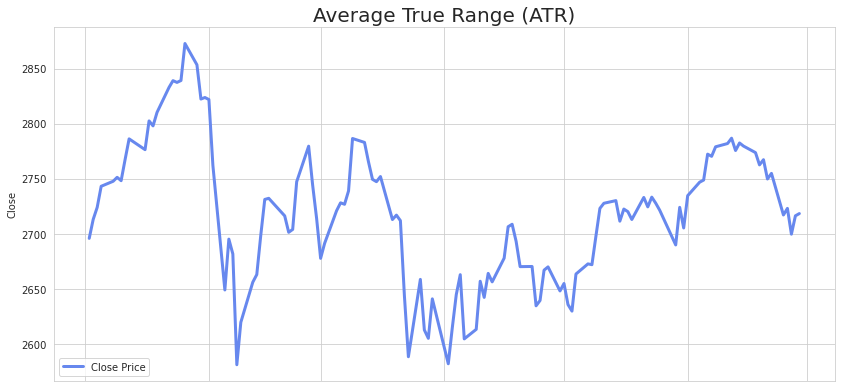

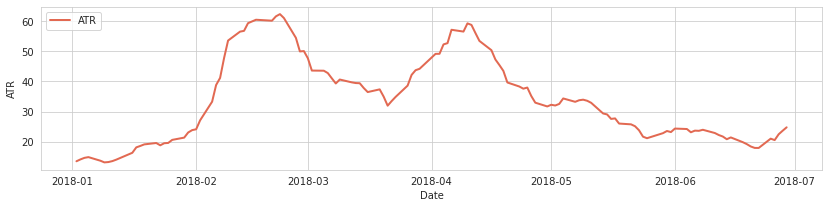

In [12]:
# Create the ATR feature

# Subtract lowest value from each period from the highest
high_low = df['High'] - df['Low']

# Take the absolute value of the close from the high
high_close = np.abs(df['High'] - df['Close'].shift())

# Same with the low
low_close = np.abs(df['Low'] - df['Close'].shift())

# Concat into a single table
ranges = pd.concat([high_low, high_close, low_close], axis=1)

# Take the largest value from each row
true_range = np.max(ranges, axis=1)

# Calculate 14 day rolling average
ATR = true_range.rolling(14).sum()/14

df['ATR'] = df.index.map(ATR)


# Use a short period of time to plot our newly created feature

df_slice = df.loc[df.index.year == 2018]
df_slice = df_slice.loc[df_slice.index < '2018-07-01']

fig, ax = plt.subplots(figsize=(14,6.5))

sns.lineplot(data=df_slice, 
             x=df_slice.index, 
             y='Close', 
             linewidth=3,
             color=color_pal[0],
             ax=ax)

ax.set(xticklabels=[])
ax.set(xlabel=None)
ax.legend(['Close Price'], loc='lower left')
ax.set_title('Average True Range (ATR)', fontsize=20)
plt.show()


fig, ax = plt.subplots(figsize=(14,3) )
sns.lineplot(data=df_slice, 
             x=df_slice.index,
             y='ATR',
             linewidth=2,
             color=color_pal[5],
             ax=ax)

ax.legend(['ATR'], loc='upper left')
plt.show()

### Relative strength index calculation with Pandas

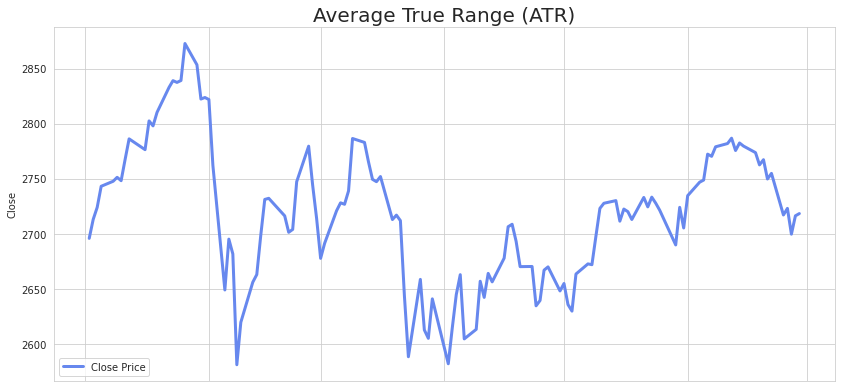

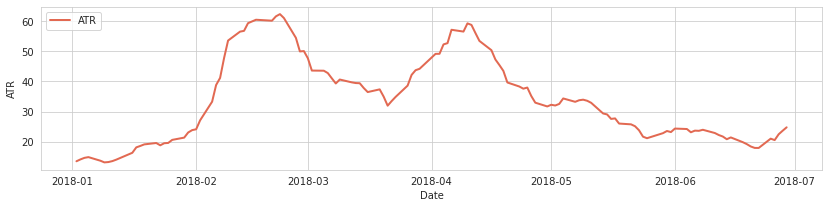

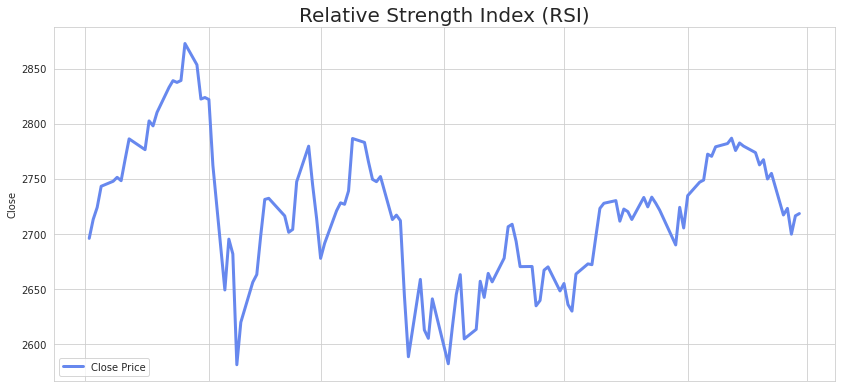

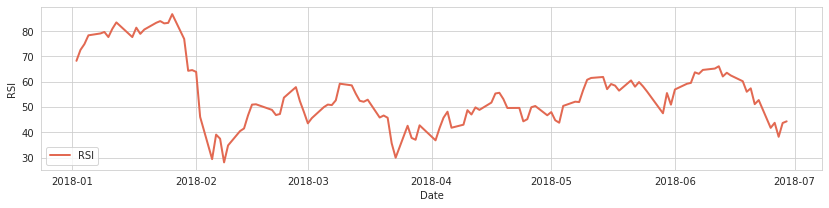

In [13]:
# Create RSI feature

# Change between close prices of each time step
close_delta = df['Close'].diff()

# Make two series, one for lower closes and one for higher closes
up = close_delta.clip(lower=0)
down = -1 * close_delta.clip(upper=0)

# Make an EMA for each
ma_up = up.ewm(com = 14 - 1, adjust=True, min_periods = 14).mean()
ma_down = down.ewm(com = 14 - 1, adjust=True, min_periods = 14).mean()

RSI = ma_up / ma_down
RSI = 100 - (100/(1 + RSI))

df['RSI'] = df.index.map(RSI)


# Use a short period of time to plot our newly created feature

df_slice = df.loc[df.index.year == 2018]
df_slice = df_slice.loc[df_slice.index < '2018-07-01']

fig, ax = plt.subplots(figsize=(14,6.5))

sns.lineplot(data=df_slice, 
             x=df_slice.index, 
             y='Close', 
             linewidth=3,
             color=color_pal[0],
             ax=ax)

ax.set(xticklabels=[])
ax.set(xlabel=None)
ax.legend(['Close Price'], loc='lower left')
ax.set_title('Average True Range (ATR)', fontsize=20)
plt.show()


fig, ax = plt.subplots(figsize=(14,3) )
sns.lineplot(data=df_slice, 
             x=df_slice.index,
             y='ATR',
             linewidth=2,
             color=color_pal[5],
             ax=ax)

ax.legend(['ATR'], loc='upper left')
plt.show()

df_slice = df.loc[df.index.year == 2018]
df_slice = df_slice.loc[df_slice.index < '2018-07-01']

fig, ax = plt.subplots(figsize=(14,6.5))

sns.lineplot(data=df_slice, 
             x=df_slice.index, 
             y='Close', 
             linewidth=3,
             color=color_pal[0],
             ax=ax)

ax.set(xticklabels=[])
ax.set(xlabel=None)
ax.legend(['Close Price'], loc='lower left')
ax.set_title('Relative Strength Index (RSI)', fontsize=20)
plt.show()


fig, ax = plt.subplots(figsize=(14,3) )
sns.lineplot(data=df_slice, 
             x=df_slice.index,
             y='RSI',
             linewidth=2,
             color=color_pal[5],
             ax=ax)

ax.legend(['RSI'], loc='lower left')
plt.show()

### Feature correlations
Let's observe the correlations between our features. This may give us more useful information to work with:

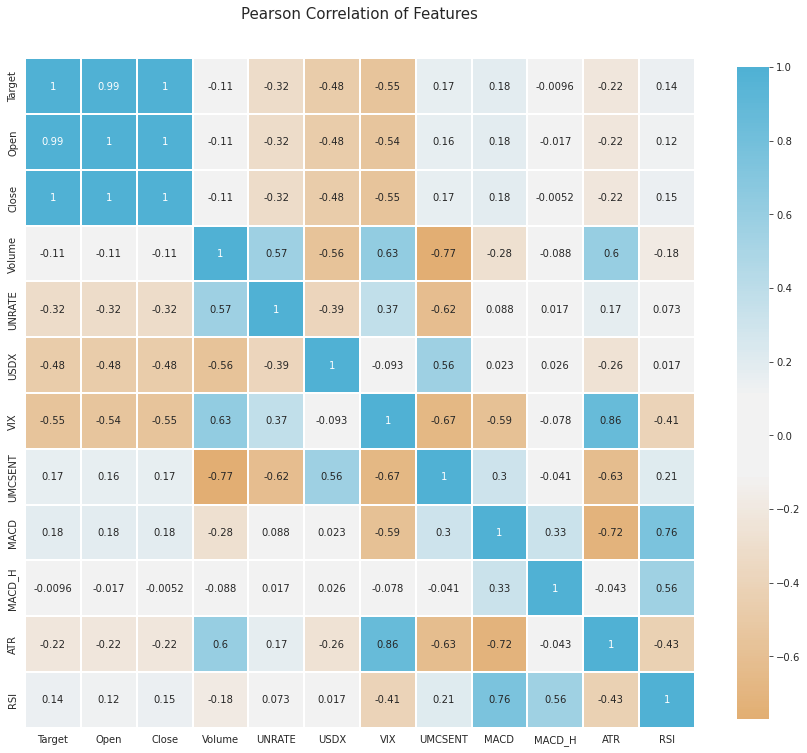

In [14]:
df['Target'] = df['Close'].shift(-1)
df.head()

feature_labels = ['Target','Open', 'Close', 'Volume', 'UNRATE', 'USDX', 'VIX', 'UMCSENT', 'MACD', 'MACD_H', 'ATR', 'RSI']
reduced_df = df[feature_labels]

corr_df = reduced_df.loc[reduced_df.index > '2008-1-1']
corr_df = reduced_df.loc[reduced_df.index < '2013-1-1']

f, ax = plt.subplots(figsize = (15, 15))
colormap = sns.diverging_palette(h_neg=45, h_pos=225, s=81, l=68, sep=30, center='light', as_cmap=True)

sns.heatmap(
    corr_df.corr('pearson'), 
    cmap=colormap,
    square=True, 
    center=0,
    cbar_kws={'shrink': .8}, 
    ax=ax,
    annot=True, 
    linewidths=0.1, vmax=1.0, linecolor='white',
    annot_kws={'fontsize': 10}
)

plt.title('Pearson Correlation of Features', y=1.05, size=15)
plt.show()

### Wavelet Theory

#### Limitations of the Fourier series
The Fourier series is a way to decompose a signal to an infinite number of sine/cosine harmonics. There is no means to  identify exactly where an event occurs. This means the Fourier series is unlikely to succeed in predicting discontinuous bursts of signal, e.g. video, music, etc.

2 types of signals:
- Stationary signals, signals with frequency content unchanged in time
- Non-stationary signals, the 'chirp' signal

Fourier series can model stationary signals well, but struggle to model non-stationary signals.

A *wavelet* is a waveform of effectively limited duration that has an average value of zero. It is defined as:

$$\large \psi _{a,b}  (t) = \frac {1} { \sqrt{a}} \psi \frac {(t-b)} { a}$$

Here, *a* and *b* are called *dilation* (scale) and *translation* (position) parameters respectively.

Wavelets allow us to model more complex (non-stationary) signals.

There are several wavelet types we could use. We're going to use Daubechies 4 (Db4) wavelets.

### Discrete Wavelet Transformation (DWT)
Discrete wavelet transform (DWT), a technique with a mathematical origin, is very
appropriate for noise filtering, data reduction, and singularity detection, which makes
it a good choice for time series data processing. DWT has been around for approximately
100 years, and it has been used extensively in a wide range of areas, such as in signal
processing, and specifically it is frequently employed for research in signal compression,
image enhancement and noise reduction.

Time series data analysis and mining is another area where researchers have recently applied DWT techniques due to its favorable properties. Although DWT has been
around for quite some time, only recently has it been adopted by database researchers
to assist in data analysis and mining for time series.



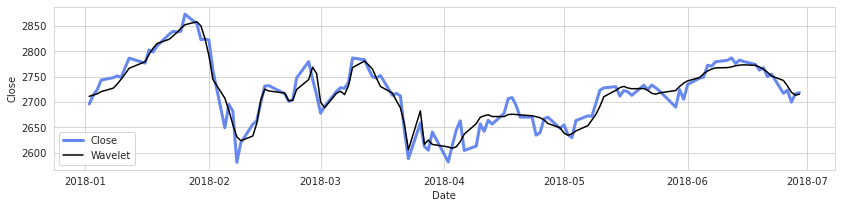

In [15]:
import pywt

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    
    wave = pywt.waverec(coeff, wavelet, mode='per')
    
    if len(x) == len(wave):
        return wave
    else:
        return wave[:-1]
    

df['Wavelet'] = denoise_signal(df['Close'])

df_slice = df.loc[df.index.year == 2018]
df_slice = df_slice.loc[df_slice.index < '2018-07-01']

fig, ax = plt.subplots(figsize=(14,3) )
sns.lineplot(data=df_slice, 
             x=df_slice.index,
             y='Close',
             linewidth=3,
             color=color_pal[0],
             ax=ax)

sns.lineplot(data=df_slice, 
             x=df_slice.index,
             y='Wavelet',
             linewidth=1.5,
             color='black',
             ax=ax)


ax.legend(['Close', 'Wavelet'], loc='lower left')
plt.show()

### Comparison of DWT to a simple moving average:


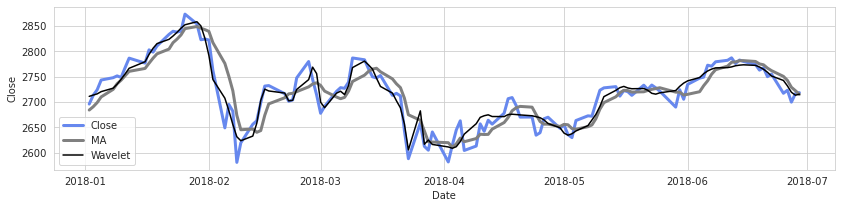

In [16]:
df['MA5'] = df['Close'].rolling(5).mean()

df_slice = df.loc[df.index.year == 2018]
df_slice = df_slice.loc[df_slice.index < '2018-07-01']

fig, ax = plt.subplots(figsize=(14,3) )
sns.lineplot(data=df_slice, 
             x=df_slice.index,
             y='Close',
             linewidth=3,
             color=color_pal[0],
             ax=ax)

sns.lineplot(data=df_slice, 
             x=df_slice.index,
             y='MA5',
             linewidth=3,
             color='gray',
             ax=ax)

sns.lineplot(data=df_slice, 
             x=df_slice.index,
             y='Wavelet',
             linewidth=1.5,
             color='black',
             ax=ax)


ax.legend(['Close','MA', 'Wavelet'], loc='lower left')
plt.show()

#### Observations:
As we can see above, a simple 5 day moving average helps us smooth things out, but notice that there is also a clear time lag effect present also. This is due to our 5 day moving average reacting more slowly to new information than the original signal. Since we are only aiming to predict a single day into the future, this presents a clear issue.

### Comparison of DWT to an exponentially weighted moving average:

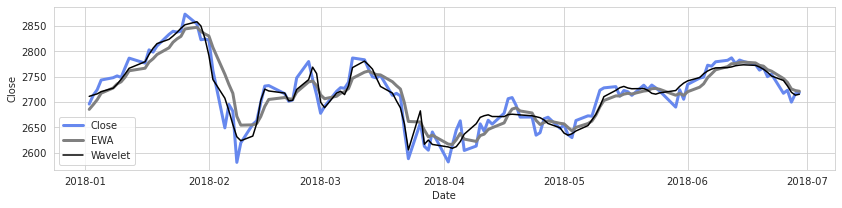

In [17]:
df['EMA5'] = df['Close'].ewm(span=5).mean()

df_slice = df.loc[df.index.year == 2018]
df_slice = df_slice.loc[df_slice.index < '2018-07-01']

fig, ax = plt.subplots(figsize=(14,3) )
sns.lineplot(data=df_slice, 
             x=df_slice.index,
             y='Close',
             linewidth=3,
             color=color_pal[0],
             ax=ax)

sns.lineplot(data=df_slice, 
             x=df_slice.index,
             y='EMA5',
             linewidth=3,
             color='gray',
             ax=ax)

sns.lineplot(data=df_slice, 
             x=df_slice.index,
             y='Wavelet',
             linewidth=1.5,
             color='black',
             ax=ax)


ax.legend(['Close','EWA', 'Wavelet'], loc='lower left')
plt.show()

#### Observations:
Although clearly less lagged than before, there is still a slight lag present in the EWA that we don't have in the wavelet or close trend lines.

It's clear that wavelets are a superior method to reduce noise compared to a simple moving average and an exponentially weighted moving average.

### Calculating the profitability of a strategy
Here, we define a function we can use to calculate the profit accumulated by a certain trading strategy. We use this to evaluate the performances of our models.

In [18]:
def calculate_profit(df, s_date, e_date, strategy=None, stake=100):
    """
    Calculates the profit from trading the S&P500 over a specific period using a specified strategy.

    The function uses opening prices as buying prices and closing prices as selling prices.

    Args:
    df (pd.DataFrame): The DataFrame containing stock data with 'Open' and 'Close' columns.
    s_date (str or datetime): The start date of the period over which to calculate profit.
    e_date (str or datetime): The end date of the period over which to calculate profit.
    strategy (list or np.array): An array-like object representing the trading strategy. 
        Each element is a binary value where 1 indicates a trade on the corresponding date and 0 
        indicates no trade. If None, the function assumes that a trade is made every day. Defaults to None.
    stake (int or float): The amount of money invested in each trade. Defaults to 100.

    Returns:
    If a trading strategy is provided, the function returns a list with three elements:
    - Total profit: The total profit from the trading period.
    - Profit per trade: The average profit per trade during the trading period.
    - Number of trades: The total number of trades made during the trading period.
    If no trading strategy is provided, the function returns the total profit from the trading period.

    """
    
    buy_prices = df.loc[(df.index>=s_date) & (df.index<=e_date)].Open.values
    sell_prices = df.loc[(df.index>=s_date) & (df.index<=e_date)].Close.values
    
    profit = sell_prices - buy_prices
    
    units = stake/buy_prices
    
    if type(strategy) != type(None):
        profit = round(sum(profit * strategy * units), 2)
        profit_per_trade = round(profit/sum(strategy), 4)
        n_trades = sum(strategy)
        return [profit, profit_per_trade, n_trades]

    else:
        return round(sum(units*profit), 2)
    

## Simple strategies to evaluate our model against:

### Strategy 1: Buy and hold
**Description**: Buy $100 of S&P 500 at the first open in the validation data (January 2nd 2018) to the final price (Dec 31st 2019)

In [19]:
# Validation period
start_date = '2018-01-02'
end_date = '2019-12-31'

# $100 stake
stake = 100

buy_price = df.loc[df.index==start_date].Close.values[0]
sell_price = df.loc[df.index==end_date].Close.values[0]
profit = sell_price - buy_price

units = stake/buy_price

profit = round(sell_price*units - buy_price*units, 2)

print("Profit for strategy 1 is: $", profit)

Profit for strategy 1 is: $ 19.84


#### Observations:
Strategy 1 produces a profit of $19.84.
It makes no predictions so we are unable to calculate an error.

### Strategy 2: Buy each open, sell each close.
**Description**: At the start of every day, buy $100 of shares. At the end of every day, sell them.


In [20]:
profit = calculate_profit(df, start_date, end_date)

print("Profit for strategy 2 is: $", profit)

Profit for strategy 2 is: $ 1.44


#### Observations:
Strategy 2 produces a profit of $1.44.

It makes no predictions so we are unable to calculate an error.

### Strategy 3: Random trading strategy.
**Description**: Randomly buy some opens and sell the following close.


In [21]:
import random 

def random_strategy(df, s_date, e_date):
    
    def coin_flip():
        return random.randint(0,1)
    
    strategy = []
    n_rows = len(df.loc[(df.index>=start_date) & (df.index<=end_date)])
    
    for trade in range(n_rows):
        strategy.append(coin_flip())
    
    return strategy


strategy = random_strategy(df, start_date, end_date)

profit = calculate_profit(df, start_date, end_date, strategy=strategy)

print("Total made was $",profit[0], "\nProfit per trade was $", profit[1],
      "\nA total of", profit[2], "trades were made.")

Total made was $ 9.16 
Profit per trade was $ 0.0347 
A total of 264 trades were made.


#### Observations:
Strategy 3 produces a **mean** profit of **\\$0.81**.

It also produces an approximately \\$0 profit per trade.

It makes no predictions so we are unable to calculate an error.

### Strategy 4: Simple momentum strategy.
**Description**: Buy an open if the open is higher than yesterday's open, then sell always sell at the close.

In [22]:
df['Open_y'] = df['Open'].shift(1)
strategy = np.array(df.loc[(df.index>=start_date) & (df.index<=end_date)].Open_y < df.loc[(df.index>=start_date) & (df.index<=end_date)].Open)

profit = calculate_profit(df, start_date, end_date, strategy)

print("Total made was $",profit[0], "\nProfit per trade was $", profit[1],
      "\nA total of", profit[2], "trades were made.")


Total made was $ 16.4 
Profit per trade was $ 0.0586 
A total of 280 trades were made.


#### Observations:
Strategy 4 produces a profit of **\\$16.40**.

It also produces a decent profit per trade of **\\$0.059**.

It makes no predictions so we are unable to calculate an error.

### Strategy 5: MACD trading strategy.
**Description**: Buy the open if the MACD fast signal crosses the slow moving signal in an upward direction.
Sell the following close.

In [23]:
strategy = df.loc[(df.index>=start_date) & (df.index<=end_date)].MACD_H > 0
    
profit = calculate_profit(df, start_date, end_date, strategy)

print("Total made was $",profit[0], "\nProfit per trade was $", profit[1],
      "\nA total of", profit[2], "trades were made.")

Total made was $ 19.88 
Profit per trade was $ 0.072 
A total of 276 trades were made.


#### Observations:
Strategy 5 produces a profit of **\\$19.88**.

It also produces a decent profit per trade of **\\$0.072**.

It makes no predictions so we are unable to calculate an error.

## Large Sample of Random Trading Strategies
Let's create a large sample of random trades to consider how luck can affect trading strategies.

Let's do a sample of 10,000 random buys and sells to compare the effects of luck on profitability.



The median random profit is 0.16
The 90th percentile random profit is $12.56
The 95th percentile random profit is $15.31
The 99th percentile random profit is $19.82
The 99.9th percentile random profit is $26.12
The 99.99th percentile random profit is $29.95


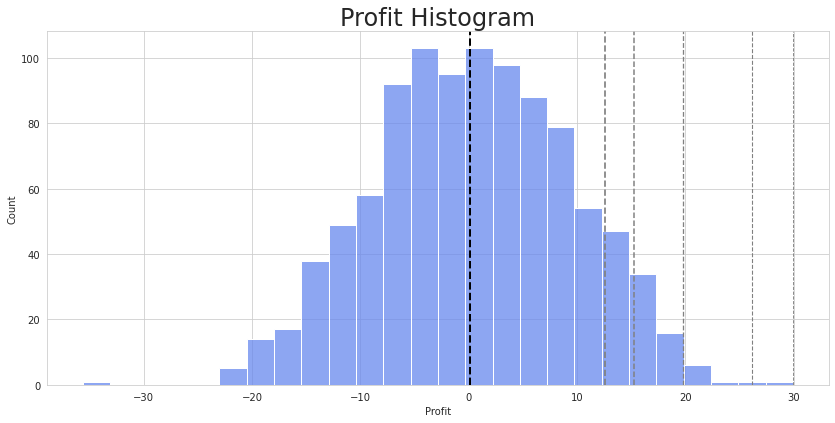

In [24]:
history = []

n_samples = 1000

for sample in range(n_samples):
    strategy = random_strategy(df, start_date, end_date)
    profit = calculate_profit(df, start_date, end_date, strategy)
    
    history.append(profit[0])
    

# Calculating percentiles:
history.sort()
median_profit = history[(round(len(history)/2))-1]
p_90_profit = history[(round(len(history)*0.9))-1]
p_95_profit = history[(round(len(history)*0.95))-1]
p_99_profit = history[(round(len(history)*0.99))-1]
p_999_profit = history[(round(len(history)*0.999))-1]
p_9999_profit = history[(round(len(history)*0.9999))-1]

print(f"The median random profit is {median_profit}")
print(f"The 90th percentile random profit is ${p_90_profit}")
print(f"The 95th percentile random profit is ${p_95_profit}")
print(f"The 99th percentile random profit is ${p_99_profit}")
print(f"The 99.9th percentile random profit is ${p_999_profit}")
print(f"The 99.99th percentile random profit is ${p_9999_profit}")

fig, ax = plt.subplots(figsize=(14,6.5))

sns.histplot(data=history, 
             color=color_pal[0],
             ax=ax)

plt.axvline(x=median_profit, color='black', linestyle='--', linewidth=2)
plt.axvline(x=p_90_profit, color='gray', linestyle='--', linewidth=1.7)
plt.axvline(x=p_95_profit, color='gray', linestyle='--', linewidth=1.5)
plt.axvline(x=p_99_profit, color='gray', linestyle='--', linewidth=1.3)
plt.axvline(x=p_999_profit, color='gray', linestyle='--', linewidth=1.1)
plt.axvline(x=p_9999_profit, color='gray', linestyle='--', linewidth=0.9)

ax.set(xlabel="Profit")
ax.set(ylabel="Count")
ax.set_title('Profit Histogram', fontsize=24)
plt.show()

# Simple Machine Learning Model

We're going to now employ a simple linear regression model to predict the close price 1 day into the future.

All of these models will be regression models and the buy decision will be made if the predicted price is higher than the current price.

We will use the same stake as before of \\$100 for each trade.

## Objective
Use past years of data to predict the next day's close price.

## Feature Selection
Selecting features for the model to use:

We're going to replace the Close feature with the wavelet transformed version, but we're going to recompute the discrete wavelet transformation after the train/test split to reduce data leakage.

We're not going to recompute any other metrics after the train/test split as their computations are all performed retrospectively.

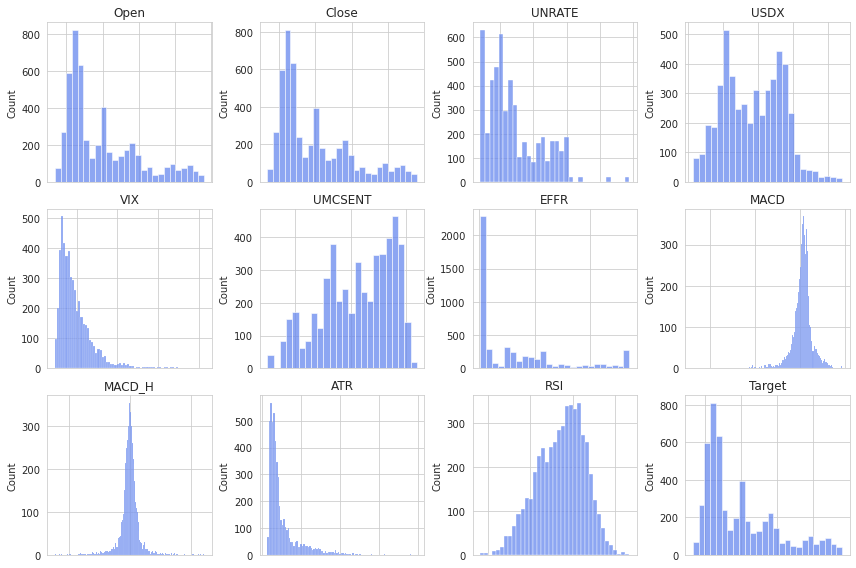

In [25]:
features = ['Open', 'Close','UNRATE', 'USDX', 'VIX', 'UMCSENT',
            'EFFR', 'MACD', 'MACD_H', 'ATR', 'RSI', 'Target']
            
full_df = df[features]

full_df['EFFR'] = pd.to_numeric(full_df.EFFR)
full_df = full_df.dropna()

cols, rows = 4, 3
f, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(12, 8))
ax = ax.flatten()

for i, feature in enumerate(full_df.columns):
    sns.histplot(x=full_df[feature], ax=ax[i], color=color_pal[0])
    ax[i].set_title(feature)
    ax[i].set(xticklabels=[])
    ax[i].set(xlabel=None)

    
f.tight_layout(w_pad=0.2, h_pad=0.5) # change padding 
plt.show()

## Splitting our Training, Validation and Testing Data
We're going to set the dates for our training, validation and testing data.

We do this first to minimise data leakage.

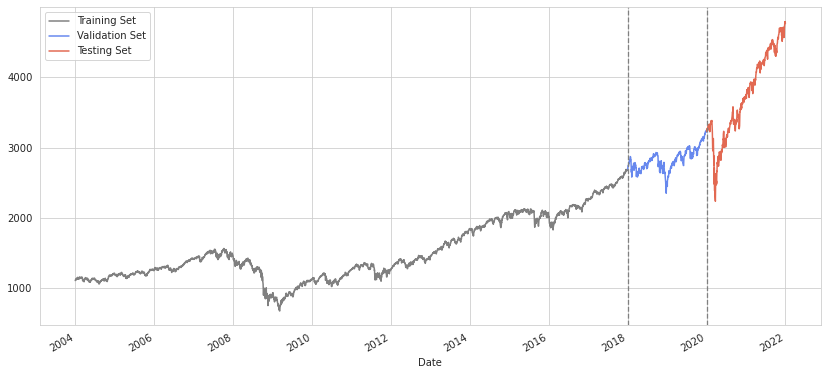

In [26]:
test_val_duration = 2
test_start = 2020
test_end = test_start + test_val_duration
val_start = test_start - test_val_duration
val_end = test_start
train_start = 2004
train_end = val_start

train_df = full_df.loc[(full_df.index.year >= train_start) & (full_df.index.year < train_end)]
val_df = full_df.loc[(full_df.index.year >= val_start) & (full_df.index.year < val_end)]
test_df = full_df.loc[(full_df.index.year >= test_start) & (full_df.index.year < test_end)]

X_train = train_df[features]
y_train = X_train.pop('Target')

X_val = val_df[features]
y_val = X_val.pop('Target')

X_test = test_df[features]
y_test = X_test.pop('Target')

# Plotting our datasets

f, ax = plt.subplots(figsize=(14,6.5))
train_df.Close.plot(ax=ax, label='Training Set', color='gray')
val_df.Close.plot(ax=ax, label='Validation Set', color=color_pal[0])
test_df.Close.plot(ax=ax, label='Testing Set', color=color_pal[5])

plt.axvline(x=str(val_start), color='gray', linestyle='--', linewidth=1.3)
plt.axvline(x=str(test_start), color='gray', linestyle='--', linewidth=1.3)

ax.legend(['Training Set', 'Validation Set', 'Testing Set'])
plt.show()

### Wavelet transformations for Open and Close features

Initially we're just going to compute the wavelet transformation for the training dataset and use that to train the model, but later we will also compute wavelet transformations of the validation and testing open/close price information.


In [27]:
X_train['Open'] = denoise_signal(X_train['Open'])
X_train['Close'] = denoise_signal(X_train['Close'])

## Measuring Error

To measure the performance (or error) of our model, we are going to use the mean absolute percentage error metric, which takes the mean percentage error of each prediction made by the model. 

In [28]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

## Simple Linear Model

First, a simple linear regression model. 

This model is not using previous timesteps, it's simply using the data available from one day to predict the price the next day. 

We would expect this model to perform better than the simple MACD model we made, but let's try it and see.

In [29]:
from sklearn.linear_model import LinearRegression

model_linreg = LinearRegression()

model_linreg.fit(X_train, y_train)

pred_linreg = model_linreg.predict(X_val)

error_linreg = mae(y_val, pred_linreg)
print("The linear regression model has an MAE of :", error_linreg)

The linear regression model has an MAE of : 18.76742772105001


In [30]:
strategy = pred_linreg > val_df.Close
profit = calculate_profit(val_df, start_date, end_date, strategy)

print("Total made was $",profit[0], "\nProfit per trade was $", profit[1],
      "\nA total of", profit[2], "trades were made.")

Total made was $ 38.57 
Profit per trade was $ 0.2256 
A total of 171 trades were made.


In [31]:
for coefficient, feature in zip(model_linreg.coef_, features):
    print(feature, ":", round(coefficient, 3))
print("Intercept :", round(model_linreg.intercept_, 3))

Open : 0.034
Close : 0.965
UNRATE : -0.111
USDX : 0.065
VIX : -0.172
UMCSENT : -0.056
EFFR : -0.396
MACD : -0.405
MACD_H : -0.116
ATR : -0.024
RSI : 0.701
Intercept : -30.906


## Plotting our predictions from linear regression.
The more closely these predictions trace the actual values, the better our model is.

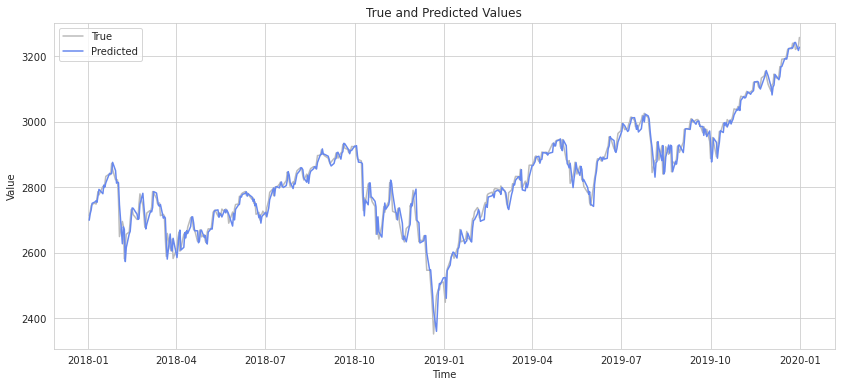

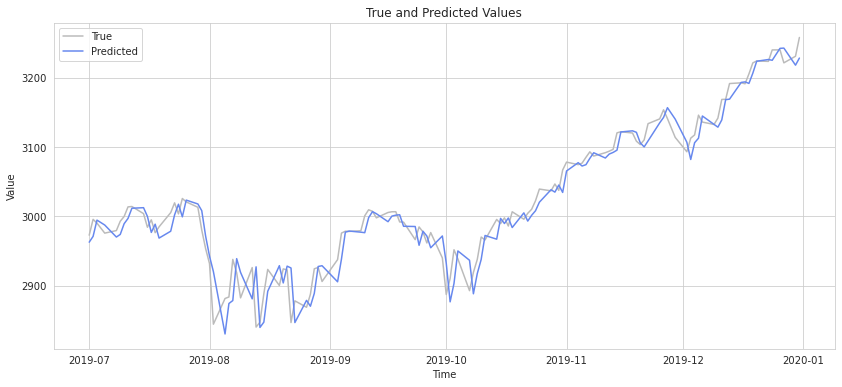

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predictions(model, X_val, y_val, start_date="2018-01-01", end_date="2019-12-31"):

    # Get truth values for reference
    true_val = y_val.loc[(y_val.index >= start_date) & (y_val.index <= end_date)]
    
    # Make predictions using the model
    pred_val = model.predict(X_val.loc[(X_val.index >= start_date) & (X_val.index <= end_date)])

    # Define dates for plotting
    plot_dates = y_val.loc[(y_val.index >= start_date) & (y_val.index <= end_date)].index    

    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(14,6))

    # Plot both values
    sns.lineplot(x=plot_dates, y=true_val, color='#bbbbbb', ax=ax)
    sns.lineplot(x=plot_dates, y=pred_val, color=color_pal[0], ax=ax)

    # Configure the plot
    ax.set(xlabel='Time', ylabel='Value', title='True and Predicted Values')
    ax.legend(['True', 'Predicted'])

    # Show the plot
    plt.show()

plot_predictions(model_linreg, X_val, y_val)
plot_predictions(model_linreg, X_val, y_val, start_date="2019-07-01", end_date="2019-12-31")

#### Observations:
- Our linear regression model has performed very well, producing a solid strategy that works well from the start to the end of the validation period.
- The 99.99th percentile of the random trading strategy was $\$$26, so the linear regression model making a profit of over $\$$38 is very impressive. 

## Percentage change
Since many of the models we want to explore are not going to extrapolate into unknown waters very well, we're going to convert some of our features into percentage change so they can work with other machine learning algorithms, including tree based algorithms and neural networks.

The features we're going to change to percentage change are:
- **Open**
- **Close**
- **Target**

We're going to achieve this by using the Pandas `pct_change()` function on each DataFrame, training, validation and testing then setting the first index of each to 0.

In [33]:
for df in [X_train, X_val, X_test]:
    df['Open_pct_change'] = df['Open'].pct_change()
    df['Open_pct_change'].iloc[0] = 0 
    df['Close_pct_change'] = df['Close'].pct_change()
    df['Close_pct_change'].iloc[0] = 0 

y_train_pct = y_train.pct_change()
y_train_pct[0] = 0
y_val_pct = y_val.pct_change()
y_val_pct[0] = 0
y_test_pct = y_test.pct_change()
y_val_pct[0] = 0

### Scaling and feature selection
We're also going to scale our features here so they can be used in conjunction with neural networks more effectively.

In [34]:
features = ['Open_pct_change', 'Close_pct_change','UNRATE', 'USDX', 
            'VIX', 'UMCSENT', 'EFFR', 'MACD', 'MACD_H', 'ATR', 'RSI']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[features])

X_train_scaled = scaler.transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])
X_test_scaled = scaler.transform(X_test[features])



## Simple Decision Tree Model

Now let's implement a simple decision tree model.

Again, this model is not using previous timesteps, it's simply using the data available from one day to predict the price the next day. 

In [35]:
from sklearn.tree import DecisionTreeRegressor

model_dtree = DecisionTreeRegressor()

model_dtree.fit(X_train_scaled, y_train_pct)

pred_dtree = model_dtree.predict(X_val_scaled)

error_dtree = mae(y_val_pct, pred_dtree)
print("MAE (% change) produced by decision tree regressor:", error_dtree)

MAE (% change) produced by decision tree regressor: 0.013938734410583057


In [36]:
strategy = pred_dtree > (val_df.Close * 0)
profit = calculate_profit(val_df, start_date, end_date, strategy)

print("Total made was $",profit[0], "\nProfit per trade was $", profit[1],
      "\nA total of", profit[2], "trades were made.")

Total made was $ 22.58 
Profit per trade was $ 0.0922 
A total of 245 trades were made.


#### Observations:
- Performance from the decision tree is comparable to our linear regression model, though our linear regression model performed better.

## A neural network regressor

A simple fully connected neural network regressor. The architecture of our network is:
- Input layer 
- 64 node dense layer
- 32 node dense layer
- 16 node dense layer
- Output layer (single node)

We're also using dropout, batch normalization and an RMSprop optimizer.

In [37]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_mlp = Sequential()

# Input layer
model_mlp.add(Flatten(input_shape=(1, X_train_scaled.shape[-1])))
model_mlp.add(BatchNormalization())

# Hidden layer 1
model_mlp.add(Dense(64, activation='elu'))  # Number of neurons can be a power of 2 (64, 128, 256, etc.)
model_mlp.add(BatchNormalization())
model_mlp.add(Dropout(0.2))  # Dropout after the activation function

# Hidden layer 2
model_mlp.add(Dense(32, activation='elu'))  
model_mlp.add(BatchNormalization())
model_mlp.add(Dropout(0.2))

# Hidden layer 3
model_mlp.add(Dense(16, activation='elu'))
model_mlp.add(BatchNormalization())
model_mlp.add(Dropout(0.2))

# Output layer
model_mlp.add(Dense(1))

# Compile the model
model_mlp.compile(optimizer=RMSprop(learning_rate=0.001), loss='mae')

# Define early stopping criteria
cb_early_stopping = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10)

# Define model checkpoint callback
cb_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# Fit the model
history = model_mlp.fit(X_train_scaled, y_train_pct,
                        batch_size=5,
                        epochs=120,
                        validation_data=(X_val_scaled, y_val_pct),
                        callbacks=[cb_early_stopping, cb_checkpoint])

# Load the saved model
from keras.models import load_model

model_mlp = load_model('best_model.h5')

# Predict
pred_mlp = model_mlp.predict(X_val_scaled)
pred_mlp = [item for sublist in pred_mlp for item in sublist]

# Calculate error
error_mlp = mae(y_val_pct, pred_mlp)
error_mlp

Epoch 1/120
705/705 [==============================] - 6s 4ms/step - loss: 0.4985 - val_loss: 0.1608
Epoch 2/120
705/705 [==============================] - 3s 4ms/step - loss: 0.1640 - val_loss: 0.0240
Epoch 3/120
705/705 [==============================] - 3s 4ms/step - loss: 0.0179 - val_loss: 0.0079
Epoch 4/120
705/705 [==============================] - 2s 4ms/step - loss: 0.0085 - val_loss: 0.0077
Epoch 5/120
705/705 [==============================] - 2s 4ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 6/120
705/705 [==============================] - 2s 3ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 7/120
705/705 [==============================] - 3s 4ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 8/120
705/705 [==============================] - 3s 4ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 9/120
705/705 [==============================] - 2s 3ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 10/120
705/705 [==============================] - 2s 3ms/step - loss: 0.0073 - val_lo

0.006546859391905453

In [38]:
pred_mlp_arr = np.array(pred_mlp)
strategy = pd.Series((pred_mlp_arr > 0).astype(int))
profit = calculate_profit(val_df, start_date, end_date, strategy)

print("Total made was $",profit[0], "\nProfit per trade was $", profit[1],
      "\nA total of", profit[2], "trades were made.")

Total made was $ 67.13 
Profit per trade was $ 0.1515 
A total of 443 trades were made.


#### Observations:
- Extraordinary performance, the model achieves over 65% return over two years of use; almost double that of the well-performing linear regression model.

We're going to add an RNN model shortly, stay tuned!